# Sentiment Analysis on IMDB Reviews 
This notebook includes a sentiment analysis on [an IMDB review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) provided by kaggle and explanation of the steps and results. The analysis consist of 3 main parts: exploratory data analysis, model building and results.

In [105]:
#import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import  GridSearchCV
from collections import Counter
import warnings;
warnings.filterwarnings('ignore')

## 1.Exploratory Data Analysis 
First we'd like to start with an initial look of the dataset. As we see below, it is a textual data with 50k rows and two columns: review and sentiment. The task is to perform sentiment analysis on the data. This will be a supervised binary text classification task as the data is labeled (sentiments) and textual (reviews). 

In [106]:
df_ = pd.read_csv('IMDB Dataset.csv')
df = df_.copy()
print(df.shape)
print(df.head())

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


* We start with checking for missingness, and replicates to make sure that data is complete and unique.

In [107]:
def is_nan(df):
    return df.isna().sum()

def make_unique(df):
    df_unique = df.drop_duplicates()
    return(df_unique)

print('NaN counts of columns: \n ', is_nan(df))
print('Shape of the unique dataset is: ', make_unique(df).shape)

NaN counts of columns: 
  review       0
sentiment    0
dtype: int64
Shape of the unique dataset is:  (49582, 2)


* As we notice, the dataset got smaller when we removed the replicates. This means that there are 418 replicate rows. Since this is a text data and not a multiple choice survey, it's quite unlikely that two people have made the exact same comment, word to word. Still let's check a review with a duplicate. 


In [108]:
#find the replicate reviews indices
df_rep = df.copy()
df_rep = df_rep[df_rep.duplicated(keep=False)]

df_rep = df_rep.groupby(list(df_rep)).apply(lambda x: tuple(x.index)).tolist()
print ('Indices of some replicates:', df_rep[0:10])


Indices of some replicates: [(34058, 47467), (29956, 31488), (2976, 47527), (7949, 32260), (18022, 22449), (25363, 30799), (14353, 39916), (23510, 30638), (12817, 44097), (15706, 41655)]


In [109]:
#check the first pair
print(df.review[34058])
print(df.review[47467])

"Go Fish" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promise.<br /><br />Its then hard to understand how she could turn out a movie made up of stereotypes that one associates with inferior sitcoms. The entire film rings hollow. I cringed the whole way through.<br /><br />Its supposed to be a look into nineties human sexuality. Well not much more here to be learned than from "In and Out". By now most of us actually do know, that there are men who are sexually attracted to women and there men who are sexually attracted to men and there are even men sexually attracted to both sexes. <br /><br />Seldom has this revelation been portrayed on the screen with so little wit and style.<br /><br />Pathetic.
"Go Fish" garnered Rose Troche rightly or wrongly the reputation of a film maker with much promise.<br /><br />Its then hard to understand how she could turn out a movie made up of stereotypes that one associates with inferior sitcoms. The entire film ring

* As we see these two reviews are exactly the same. It's not possible that these two comments belong to two different people. So, we would like to get rid of them not to cause any bias in the data. The new dataset has 49582 rows.

In [110]:
df = make_unique(df)
print(df.shape)

(49582, 2)


* Later we would like to see the distribution of each label in the data as an unbalanced dataset might cause false modelling if it's not handled accordingly. As we see from the bar plot below, there are two unique labels and they are fairly balanced, yet we'll keep the difference in mind while splitting data into training and test sets.

[Text(0.5, 1.0, 'Number of entries in each sentiment')]

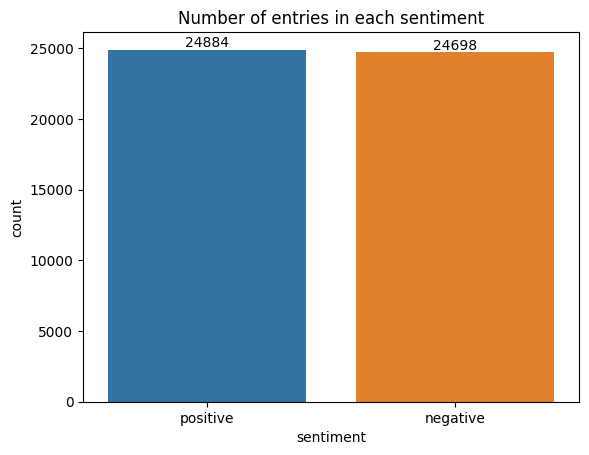

In [111]:
ax = sns.countplot(x=df['sentiment'])
ax.bar_label(ax.containers[0])
ax.set(title='Number of entries in each sentiment')

Now we'll move onto text preprocessing to hae a smaller more quality data. 

### 1.2. Text Preprocessing 
After a quick look at the dataset and being sure that it is complete and unique we can move on to the preprocessing of the text before starting modelling. This preprocessing part will include 4 steps. These steps will clean the data from unnecesary attributes of texts that does not help the classification algorithm.  

* Get rid of HTML expression and any special characters:
    * Special characters do not give any indication on the sentiment of the review, and thus unnecessary. Panctuation cause the same words that are in the middle and at the end of a sentence to be perveived as different words. For instance, 'bad' and 'bad.' are different entities for the computer. 
* Convert all letters to lower case:
    * Similar to panctuation, the same word starting with a capital and a lowercase letter will be read as two different words.
* Get rid of stopwords:
    * Stopwords are words that are commonly used in a natural language yet are insignificant in terms of the context such as 'it', 'I' or 'an' etc. Here we'll use the english stopwords list from nltk. 
* Stemming: 
    * Stemming is a process where we get rid of suffixes. This will allow the words coming from the same root, such as happy and happier, to be understood as the same entity which in the end will result in better model performance. 



In [112]:
#get stopwords and initilize stemmer
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

In [113]:
#preprocessing funtion for a single review
def preprocess(review):
    #step-1: get rit of special chars
    review = BeautifulSoup(review).get_text()
    regex = re.compile('[^a-zA-Z]')
    review = regex.sub(' ', review)
    #step-2: lower all the letters
    review = review.lower()
    #step-3 and -4: get rid of stop words and stem 
    review = " ".join(ps.stem(word) for word in review.split() if word not in stopwords)
    return(review)


* Below we see how a single review is tranformed after preprocessing. There are no punctuations and words, or sentences doesn't necessarily mean anything. It is much clear here how stemming works. Now we'll apply the same preprocessing function to all reviews

In [115]:
review = df.review[0]
print(preprocess(review))

one review mention watch oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side


In [116]:
#apply preprocessing to all reviews
df['review'] = df['review'].map(lambda x: preprocess(x))
df.head

<bound method NDFrame.head of                                                   review sentiment
0      one review mention watch oz episod hook right ...  positive
1      wonder littl product film techniqu unassum old...  positive
2      thought wonder way spend time hot summer weeke...  positive
3      basic famili littl boy jake think zombi closet...  negative
4      petter mattei love time money visual stun film...  positive
...                                                  ...       ...
49995  thought movi right good job creativ origin fir...  positive
49996  bad plot bad dialogu bad act idiot direct anno...  negative
49997  cathol taught parochi elementari school nun ta...  negative
49998  go disagre previou comment side maltin one sec...  negative
49999  one expect star trek movi high art fan expect ...  negative

[49582 rows x 2 columns]>

### 1.3 Term Frequencies
* Now we'd like to see the disribution of the most common terms in each label. To see that we plot the top 50 words with highest frequencies. We call them terms, not words, because after the text preprocessing they are not actual words anymore. 

In [117]:
#merge positive and negative reviews 
#positive reviews
df_pos = df.loc[df['sentiment'] == 'positive']
pos = ' '.join(df_pos.review).split()
#negative reviews
df_neg = df.loc[df['sentiment'] == 'negative']
neg = ' '.join(df_neg.review).split()

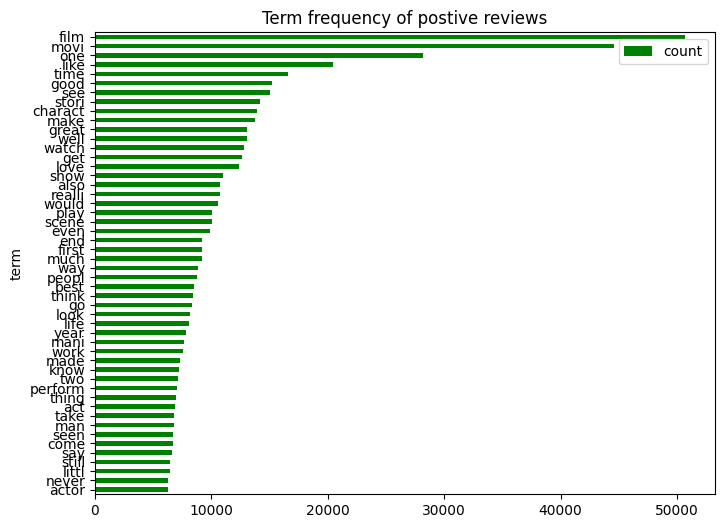

In [118]:
#get most common 50 term's counts into a dataframe
pos_term_freq = pd.DataFrame(Counter(pos).most_common(50), columns=['term', 'count'])

#plot postive term frequencies
fig, ax = plt.subplots(figsize=(8, 6))
pos_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color="green")
ax.set_title("Term frequency of postive reviews")
plt.show()

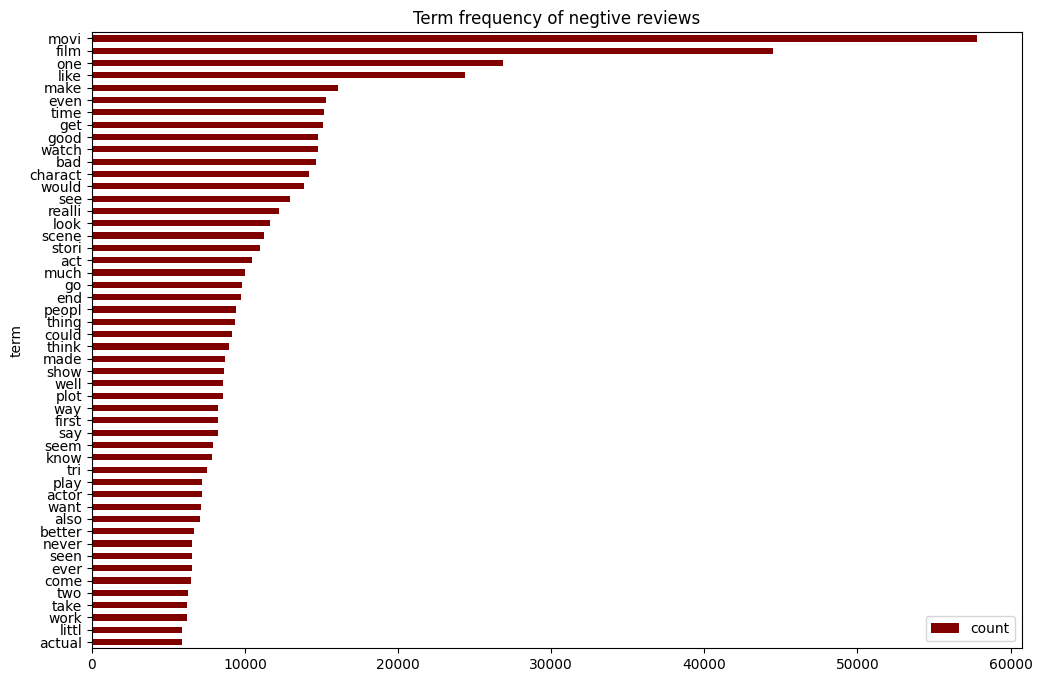

In [119]:
#get most common 50 term's counts into a dataframe
neg_term_freq = pd.DataFrame(Counter(neg).most_common(50), columns=['term', 'count'])

#plot negative term frequencies
fig, ax = plt.subplots(figsize=(12, 8))
neg_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color="maroon")
ax.set_title("Term frequency of negtive reviews")
plt.show()

 * We realize that negative and postive words share some words in their most common term plots. We'd also like to get rid of these common terms between positive and negative reviews as we believe that they will not contribute much towards the distinction of two classes. It is a similar approach as the stopword removal.  

In [120]:
common_terms = set(pos_term_freq.term) & set(neg_term_freq.term)
print('The number of terms that occured in both sentiments top 50 terms:', len(common_terms))

The number of terms that occured in both sentiments top 50 terms: 41


In [121]:
#get rid of common terms
def remove_common(review):
    return(" ".join(word for word in review.split() if word not in common_terms))

df['review'] = df['review'].map(lambda x: remove_common(x))


* Now we'd like to see the number of unique terms we ended up with after all preprocessing. Because this will be the number of features when we vectorize the text. As it can be seen it's still quite a high number of feature to feed into the model. 

In [122]:
#all reviews
print('Total word count:', df['review'].apply(lambda x: len(x.split(' '))).sum())
all_terms = ' '.join(df.review).split()
print('The total number of unique terms:', len(set(all_terms)) )

Total word count: 4835854
The total number of unique terms: 70922


## 2. Modelling
* In this section we'll compare two common text classification algorithms: Multinomial Naive Bayes (nb) and Logistic Regression (logreg). We'll also tune the hyperparameters via gridsearch and compare both models with their best parameters. 

* We start with splitting the dataset into training, and test sets. As a rule of thumb, we split data 80/20.

* Then we will transform the dataset via TFIDFvectorizer before feeding into the models. This is a Bag-of-Words (BOW) technique where each review is transformed into a numerical vector taken into acount of word and document frequencies (for detailed info please [refer](https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530)). This step is necessary for text classification algorithms to interpret text data, although different vectorization methods can be used. As we discovered in EDA, the number unique terms is 70922, we'd like to set a limit on vectorizer such that it'll only include the top 5000 terms. 

* Let's start with splitting the dataset.

In [123]:
#train test split 
X = df.review
y = df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)
print('The size of training set: ',len(X_train))
print('The size of test set: ',len(X_test))

The size of training set:  39665
The size of test set:  9917


* Now we'll train both models initially with training set.

In [124]:
#fit Naive Bayes 
nb = Pipeline([('vect', TfidfVectorizer(max_features=5000)), 
                ('clf', MultinomialNB())])
 
nb.fit(X_train, y_train)


Pipeline(steps=[('vect', TfidfVectorizer(max_features=5000)),
                ('clf', MultinomialNB())])

In [125]:
#fit Logistic Regression
logreg = Pipeline([('vect', TfidfVectorizer(max_features=5000)), 
                   ('clf', LogisticRegression())])
 
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=5000)),
                ('clf', LogisticRegression())])

* Since it's a fairly balanced dataset and we perform binary classifications, we can use accuracy to compare model performances. If it was an imbalanced dataset where misclassification is less tolerable f-1 score would be more suitable. 
* We set parameters grids to find the parameters that gives the best accuracy with training set. Multinomial Naive Bayes only has one parameter alpha to be discovered while logistic regression has three: solver, penalty, C. 

In [126]:
#tune alpha of Naive Bayes classifier
param={'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
gs_nb=GridSearchCV(nb,param,scoring='accuracy',cv=10)
gs_nb.fit(X_train, y_train)
print('Best score:', gs_nb.best_score_)
print('Best alpha:', gs_nb.best_params_)

Best score: 0.8543300496875318
Best alpha: {'clf__alpha': 10}


In [127]:
#tune hyperparameters of logistic regression classifier
param= {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
gs_logreg =GridSearchCV(logreg,param,scoring='accuracy',cv=10)
gs_logreg.fit(X_train, y_train)
print('Best score:', gs_logreg.best_score_)
print('Best parameters:', gs_logreg.best_params_)

Best score: 0.8837010035261915
Best parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


## 3. Results 
* We can see the training and test set acccuracies of both model in the following. We see that test accuracies are sligtly less than training accuracies. It's expected as we tuned hyperparameters on training set. 
* Although they perfomed quite similar, logistic regression is the winner algorithm with 0.88 comparred to 0.857 accuracy on the test set. In the end of this study logistic regression classifer is chosen to perform sentiment analysis.

In [128]:
#results of NB
print('Training accuracy of Naive Bayes:', round(accuracy_score(y_train, gs_nb.predict(X_train)),3))
print('Test accuracy of Naive Bayes:', round(accuracy_score(y_test, gs_nb.predict(X_test)),3))

#results of LogReg
print('Training accuracy of Logistic Regression:', round(accuracy_score(y_train, gs_logreg.predict(X_train)),3))
print('Test accuracy of Logistic Regression:', round(accuracy_score(y_test, gs_logreg.predict(X_test)),3))

Training accuracy of Naive Bayes: 0.863
Test accuracy of Naive Bayes: 0.857
Training accuracy of Logistic Regression: 0.909
Test accuracy of Logistic Regression: 0.888


## 4. Discussion

* This is a brief study comparing two common classification algorithms. It can definitely be improved. The following bullet points are only a few that comes to mind immediately:
    * EDA could be improved by looking more into word count statistics, review lenghts etc. 
    * More feature engineering could be tried. New non-textual features could be generated.  
    * Many more different classification algorithms could be compared such as random forest or support vector machines. 
    * We got rid of the most frequent commong words between reviews belong to twp different sentiments. However we never checked if it actually improved our model or worsened. A baseline model with basic text processing and classification algorithms with default hyperparameters could be useful. 
    * We used grid search with 10 fold cross validation to tune the hyperparameters. Yet a separate validation set could be crated to tune the hyperparameters. Data is large and balanced enough to split it into three sets. 
